Data from the paper:  
[D'Souza, M. L., & Hebert, P. D. (2018). Stable baselines of temporal turnover underlie high beta diversity in tropical arthropod communities. Molecular ecology, 27(10), 2447-2460.](http://biodiversitygenomics.net/site/wp-content/uploads/2018/06/2018-DSouza-Stable-baselines-of-temporal-turnover.pdf) [(Supplement)](https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2Fmec.14693&file=mec14693-sup-0001-Supinfo.pdf)

Data can be obtained from:  
1. Go to BOLD4: http://www.boldsystems.org/index.php
2. Select 'Databases'
3. Select 'Public Data Portal'
4. Type in 'DS-MECNP'

Start the ipcluster: `ipcluster start -n 40 --cluster-id="cusuco" --daemonize`

In [1]:
!ls

bold_data.txt  cusuco_arthropods_preprocessing.ipynb  fasta.fas  fastas


## Read in the metadata
We don't like spaces in the 'exactsite' field, so we'll replace with underscore.

In [216]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import subprocess
import itertools
import ipyparallel as ipp
import os
import shutil
import easyCGD

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
    
fastadir = "/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
meta = pd.read_csv("bold_data.txt", sep="\t", index_col=0)
meta["exactsite"] = meta["exactsite"].str.replace(" ", "_")
meta["notes"]

processid
GMHDA020-13           Collected from June 15-22 2012
GMHDA061-13           Collected from June 15-22 2012
GMHDA097-13           Collected from June 15-22 2012
GMHDA230-13           Collected from June 15-22 2012
GMHDA338-13           Collected from June 15-22 2012
GMHDA384-13           Collected from June 15-22 2012
GMHDB121-13           Collected from June 22-29 2012
GMHDC015-13       Collected from June 29-July 4 2012
GMHDC115-13       Collected from June 29-July 4 2012
GMHDC161-13       Collected from June 29-July 4 2012
GMHDD069-13            Collected from July 4-13 2012
GMHDD140-13            Collected from July 4-13 2012
GMHDE035-13           Collected from July 13-20 2012
GMHDE155-13           Collected from July 13-20 2012
GMHDE230-13           Collected from July 13-20 2012
GMHDF011-13           Collected from July 20-27 2012
GMHDF072-13           Collected from July 20-27 2012
GMHDF109-13           Collected from July 20-27 2012
GMHDF149-13           Collected from

## Get the site list and make the fasta outdirs

In [12]:
sites = list(set(meta["exactsite"]))
sites

['El_Danto', 'Base_Camp', 'El_Cortecito', 'Guanales', 'Cantiles']

## Use the bold ID as the organizing unit
Some samples don't have the 'bin_uri' set, about 10%. Let just ignore these for now

In [196]:
print("Number of samples w/o BIN ID: {}".format(np.sum(meta["bin_uri"].isnull())))
## Get just the good ones
print(len(meta))
no_bin = meta[meta["bin_uri"].isnull()]
meta = meta[~meta["bin_uri"].isnull()]
print(len(meta), len(no_bin))

Number of samples w/o BIN ID: 8215
59767
51552 8215


## Create a dict mapping "proccessid" (sample name) to "bin_uri" (OTU)

In [13]:
pid_to_bin_dict = {}
#for idx, row in has_bin[["processid", "bin_uri"]].iterrows():
for idx, uri in meta[["bin_uri"]].iterrows():
    pid_to_bin_dict[idx] = uri
print(list(pid_to_bin_dict.values())[:20])
#has_bin[["processid", "bin_uri"]]
#has_bin[["bin_uri"]]

[bin_uri    BOLD:ACD3595
Name: GMHDA020-13, dtype: object, bin_uri    BOLD:ACD2774
Name: GMHDA061-13, dtype: object, bin_uri    BOLD:ACD2844
Name: GMHDA097-13, dtype: object, bin_uri    BOLD:ACF7207
Name: GMHDA230-13, dtype: object, bin_uri    BOLD:ACF8348
Name: GMHDA338-13, dtype: object, bin_uri    BOLD:ACF6516
Name: GMHDA384-13, dtype: object, bin_uri    BOLD:ACF9349
Name: GMHDB121-13, dtype: object, bin_uri    BOLD:ACD3764
Name: GMHDC015-13, dtype: object, bin_uri    BOLD:ACD3224
Name: GMHDC115-13, dtype: object, bin_uri    BOLD:ACF9238
Name: GMHDC161-13, dtype: object, bin_uri    BOLD:ACD3260
Name: GMHDD069-13, dtype: object, bin_uri    BOLD:ACE1746
Name: GMHDD140-13, dtype: object, bin_uri    BOLD:ACF8543
Name: GMHDE035-13, dtype: object, bin_uri    BOLD:ACF6992
Name: GMHDE155-13, dtype: object, bin_uri    BOLD:ACD3258
Name: GMHDE230-13, dtype: object, bin_uri    BOLD:ACF7442
Name: GMHDF011-13, dtype: object, bin_uri    BOLD:ACG1235
Name: GMHDF072-13, dtype: object, bin_uri    BO

## Parse the giant fasta file into fastas per OTU per sampling site

In [208]:
def parse_fasta_file(fasta_file, output_path="fastas", quiet=True):

    ## Just automaticallyl clean up any fastadir that already exists and recreate the directory structure
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    for site in sites:
        if not os.path.exists(os.path.join(output_path, site)):
            os.mkdir(os.path.join(output_path, site))

    ## Parse the fasta file into a dictionary of sample IDs and sequences
    miss_dict = {}
    with open(fasta_file, 'r') as fasta:
        for line1,line2 in itertools.zip_longest(*[fasta]*2):
            key = line1.strip().strip(">").split("|")[0]
            seq = line2.strip()

            try:
                otu = meta.loc[key]["bin_uri"]
                if otu == "nan":
                    raise Exception("Sample w/o bin_uri")
                site = meta.loc[key]["exactsite"]
                with open("{}/{}/{}.fasta".format(output_path, site, otu), 'a+') as outfile:
                    outfile.write("{}\n{}\n".format(">"+key, seq))
#                with open("{}/{}/Combined/{}.fasta".format(output_path, site, otu), 'a+') as outfile:
#                    outfile.write("{}\n{}\n".format(">"+key, seq))

            except Exception as inst:
                miss_dict[key] = seq
                if not quiet:
                    print("{} failed - {}".format(key, inst))
                pass
    return miss_dict
missed = parse_fasta_file("fasta.fas", "fastas", quiet=True)

## Align fastas
It would be nice if we could guarantee the fastas we get are already aligned, but often times they aren't, so here we'll do a "quick" alignment. 

In [54]:
ipclient = ipp.Client(cluster_id="cusuco")
print(len(ipclient))
lbview = ipclient.load_balanced_view()

40


/home/isaac/miniconda2/envs/GIS/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@goatzilla')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [222]:
def align(f):
    muscle_bin = "/home/isaac/miniconda2/envs/MESS/bin/muscle"
    cmd = "cat {} | {} -quiet > {}; mv {} {}".format(f, muscle_bin, f+".tmp", f+".tmp", f)
    res = subprocess.check_output(cmd, shell=True)


In [ ]:
for site in sites:
    print(site)
    fdir = os.path.join(fastadir, site)
    for f in glob.glob(fdir + "/*"):
        print(f)
        align(f)

El_Danto
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5337.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5337.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5337.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5337.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5337.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3664.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3664.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3664.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3664.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_a

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0862.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0862.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0862.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0862.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0862.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE1764.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE1764.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE1764.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE1764.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7195.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7195.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7195.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7195.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7195.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE0363.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE0363.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE0363.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE0363.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9209.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9209.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9209.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9209.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9209.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3059.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3059.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3059.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3059.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF5984.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF5984.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF5984.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF5984.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF5984.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8595.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8595.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8595.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8595.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7024.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7024.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7024.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7024.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT7024.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4093.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4093.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4093.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4093.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0171.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0171.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0171.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0171.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0171.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9896.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9896.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9896.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9896.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6873.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6873.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6873.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6873.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6873.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4547.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4547.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4547.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4547.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3117.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3117.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3117.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3117.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3117.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD8987.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD8987.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD8987.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD8987.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9819.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9819.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9819.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9819.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS9819.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACG3868.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACG3868.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACG3868.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACG3868.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT5298.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT5298.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT5298.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT5298.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT5298.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ7312.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ7312.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ7312.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ7312.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4681.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4681.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4681.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4681.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT4681.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE1842.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE1842.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE1842.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE1842.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT3567.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT3567.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT3567.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT3567.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT3567.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ8518.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ8518.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ8518.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ8518.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0368.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0368.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0368.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0368.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0368.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8724.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8724.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8724.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8724.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT1280.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT1280.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT1280.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT1280.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT1280.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0860.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0860.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0860.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0860.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2558.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2558.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2558.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2558.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2558.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3595.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3595.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3595.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD3595.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8015.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8015.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8015.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8015.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACS8015.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6397.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6397.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6397.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACF6397.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2968.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2968.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2968.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2968.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT2968.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5071.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5071.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5071.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5071.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9762.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9762.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9762.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9762.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACD9762.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0848.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0848.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0848.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACT0848.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACR6466.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACR6466.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACR6466.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACR6466.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACR6466.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE2140.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE2140.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE2140.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACE2140.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5532.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5532.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5532.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5532.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Danto/BOLD:ACJ5532.fasta
b''
El_Cortecito
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0720.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0720.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0720.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0720.fasta.tmp /home/isaac/SGD_empi

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9128.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9128.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9128.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9128.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9128.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9213.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9213.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9213.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9213.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8999.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8999.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8999.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8999.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8999.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8377.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8377.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8377.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8377.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4705.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4705.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4705.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4705.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4705.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT8070.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT8070.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT8070.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT8070.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1783.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1783.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1783.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1783.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1783.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2271.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2271.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2271.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2271.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9188.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9188.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9188.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9188.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9188.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2038.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2038.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2038.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2038.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7595.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7595.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7595.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7595.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7595.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6569.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6569.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6569.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6569.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9113.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9113.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9113.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9113.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9113.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ8723.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ8723.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ8723.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ8723.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8858.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8858.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8858.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8858.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8858.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8324.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8324.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8324.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8324.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6586.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6586.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6586.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6586.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6586.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0346.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0346.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0346.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0346.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9192.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9192.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9192.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9192.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9192.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8400.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8400.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8400.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8400.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA6540.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA6540.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA6540.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA6540.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA6540.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0589.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0589.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0589.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0589.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABW5102.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABW5102.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABW5102.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABW5102.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABW5102.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8483.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8483.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8483.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8483.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8358.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8358.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8358.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8358.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8358.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6958.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6958.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6958.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6958.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8470.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8470.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8470.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8470.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8470.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8912.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8912.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8912.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8912.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8477.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8477.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8477.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8477.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACR8477.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8083.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8083.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8083.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8083.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9720.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9720.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9720.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9720.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9720.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:AAY4975.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:AAY4975.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:AAY4975.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:AAY4975.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4145.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4145.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4145.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4145.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ4145.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6685.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6685.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6685.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6685.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3351.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3351.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3351.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3351.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3351.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8468.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8468.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8468.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8468.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ7303.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ7303.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ7303.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ7303.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ7303.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACV4905.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACV4905.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACV4905.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACV4905.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6136.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6136.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6136.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6136.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6136.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8301.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8301.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8301.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8301.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3682.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3682.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3682.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3682.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT3682.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0040.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0040.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0040.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0040.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7339.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7339.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7339.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7339.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7339.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1632.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1632.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1632.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE1632.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2046.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2046.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2046.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2046.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE2046.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8777.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8777.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8777.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8777.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ5012.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ5012.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ5012.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ5012.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ5012.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT4631.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT4631.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT4631.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT4631.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0762.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0762.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0762.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0762.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0762.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:AAZ0628.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:AAZ0628.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:AAZ0628.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:AAZ0628.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9774.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9774.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9774.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9774.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF9774.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS0137.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS0137.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS0137.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS0137.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9714.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9714.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9714.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9714.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9714.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6615.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6615.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6615.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACJ6615.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6162.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6162.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6162.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6162.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6162.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8874.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8874.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8874.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8874.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7756.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7756.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7756.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7756.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7756.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8140.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8140.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8140.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8140.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9975.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9975.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9975.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9975.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9975.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9167.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9167.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9167.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9167.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8449.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8449.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8449.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8449.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8449.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5624.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5624.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5624.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5624.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7291.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7291.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7291.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7291.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7291.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF7887.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF7887.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF7887.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF7887.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABV3042.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABV3042.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABV3042.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABV3042.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ABV3042.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA8938.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA8938.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA8938.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ADA8938.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8147.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8147.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8147.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8147.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8147.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF8567.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF8567.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF8567.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACF8567.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5525.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5525.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5525.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5525.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT5525.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9939.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9939.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9939.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD9939.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8635.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8635.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8635.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8635.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8635.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD2773.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD2773.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD2773.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACD2773.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9004.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9004.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9004.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9004.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS9004.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7199.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7199.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7199.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT7199.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0107.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0107.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0107.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0107.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACE0107.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6628.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6628.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6628.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACT6628.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8340.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8340.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8340.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8340.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS8340.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS5495.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS5495.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS5495.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/El_Cortecito/BOLD:ACS5495.fasta.tmp /home/isaac/S

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2875.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2875.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2875.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2875.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2875.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7087.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7087.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7087.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7087.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7969.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7969.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7969.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7969.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7969.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF9746.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF9746.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF9746.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF9746.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2499.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2499.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2499.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2499.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2499.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9428.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9428.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9428.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9428.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8350.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8350.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8350.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8350.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8350.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADF6848.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADF6848.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADF6848.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADF6848.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD3664.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD3664.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD3664.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD3664.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD3664.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY4970.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY4970.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY4970.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY4970.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9811.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9811.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9811.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9811.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9811.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4997.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4997.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4997.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4997.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8673.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8673.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8673.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8673.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8673.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0822.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0822.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0822.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0822.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT0920.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT0920.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT0920.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT0920.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT0920.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3872.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3872.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3872.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3872.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8242.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8242.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8242.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8242.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8242.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2193.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2193.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2193.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2193.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5958.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5958.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5958.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5958.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5958.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7516.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7516.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7516.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7516.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4509.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4509.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4509.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4509.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4509.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4434.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4434.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4434.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4434.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6634.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6634.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6634.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6634.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6634.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8644.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8644.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8644.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8644.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8509.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8509.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8509.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8509.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8509.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY8510.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY8510.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY8510.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY8510.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0054.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0054.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0054.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0054.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0054.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6379.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6379.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6379.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6379.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAL5971.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAL5971.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAL5971.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAL5971.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAL5971.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6889.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6889.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6889.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6889.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8361.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8361.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8361.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8361.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8361.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9689.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9689.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9689.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9689.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF8177.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF8177.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF8177.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF8177.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF8177.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9110.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9110.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9110.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9110.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1726.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1726.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1726.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1726.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1726.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8929.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8929.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8929.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8929.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8487.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8487.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8487.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8487.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8487.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA5523.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA5523.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA5523.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA5523.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8333.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8333.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8333.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8333.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8333.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6856.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6856.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6856.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6856.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7756.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7756.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7756.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7756.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7756.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9102.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9102.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9102.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9102.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1691.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1691.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1691.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1691.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1691.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9882.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9882.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9882.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9882.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4727.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4727.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4727.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4727.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4727.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8832.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8832.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8832.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8832.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4656.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4656.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4656.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4656.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4656.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9738.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9738.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9738.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9738.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACX9730.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACX9730.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACX9730.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACX9730.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACX9730.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6645.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6645.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6645.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6645.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0599.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0599.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0599.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0599.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0599.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8589.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8589.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8589.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8589.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4689.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4689.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4689.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4689.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4689.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ2642.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ2642.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ2642.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ2642.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9207.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9207.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9207.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9207.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9207.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6697.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6697.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6697.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6697.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7991.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7991.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7991.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7991.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7991.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0466.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0466.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0466.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0466.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0714.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0714.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0714.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0714.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0714.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2526.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2526.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2526.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2526.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8170.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8170.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8170.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8170.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8170.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7464.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7464.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7464.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7464.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADD4640.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADD4640.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADD4640.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADD4640.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADD4640.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9659.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9659.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9659.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9659.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8494.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8494.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8494.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8494.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8494.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6014.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6014.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6014.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6014.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4865.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4865.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4865.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4865.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4865.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD2168.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD2168.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD2168.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD2168.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ5357.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ5357.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ5357.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ5357.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ5357.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT5206.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT5206.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT5206.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT5206.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8973.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8973.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8973.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8973.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8973.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAX6508.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAX6508.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAX6508.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAX6508.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5265.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5265.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5265.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5265.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5265.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5270.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5270.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5270.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ5270.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4643.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4643.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4643.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4643.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4643.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3006.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3006.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3006.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3006.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6178.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6178.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6178.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6178.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6178.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1749.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1749.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1749.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1749.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0201.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0201.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0201.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0201.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0201.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1701.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1701.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1701.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1701.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0314.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0314.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0314.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0314.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0314.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8771.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8771.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8771.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8771.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2441.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2441.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2441.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2441.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2441.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6631.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6631.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6631.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6631.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9076.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9076.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9076.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9076.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS9076.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8587.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8587.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8587.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8587.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACR6355.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACR6355.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACR6355.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACR6355.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACR6355.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0586.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0586.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0586.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0586.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT2617.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT2617.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT2617.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT2617.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT2617.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0117.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0117.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0117.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0117.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1737.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1737.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1737.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1737.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1737.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6955.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6955.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6955.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6955.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8278.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8278.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8278.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8278.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8278.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0690.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0690.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0690.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0690.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7284.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7284.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7284.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7284.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7284.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2054.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2054.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2054.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2054.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0152.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0152.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0152.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0152.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0152.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7369.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7369.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7369.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7369.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1555.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1555.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1555.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1555.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1555.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6479.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6479.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6479.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6479.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8833.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8833.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8833.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8833.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8833.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2549.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2549.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2549.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2549.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3386.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3386.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3386.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3386.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3386.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9813.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9813.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9813.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9813.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8677.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8677.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8677.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8677.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8677.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7932.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7932.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7932.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7932.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2071.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2071.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2071.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2071.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2071.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1623.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1623.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1623.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1623.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8702.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8702.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8702.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8702.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ8702.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAF0805.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAF0805.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAF0805.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAF0805.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8294.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8294.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8294.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8294.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8294.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4393.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4393.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4393.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4393.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4809.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4809.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4809.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4809.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA4809.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA5959.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA5959.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA5959.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA5959.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8222.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8222.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8222.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8222.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8222.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6528.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6528.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6528.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ6528.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2275.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2275.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2275.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2275.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2275.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5700.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5700.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5700.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK5700.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2032.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2032.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2032.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2032.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB2032.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7363.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7363.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7363.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7363.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6487.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6487.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6487.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6487.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ6487.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ7943.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ7943.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ7943.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ7943.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2350.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2350.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2350.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2350.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2350.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8766.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8766.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8766.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8766.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8448.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8448.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8448.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8448.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8448.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0728.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0728.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0728.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0728.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACG2906.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACG2906.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACG2906.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACG2906.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACG2906.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7284.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7284.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7284.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7284.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3841.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3841.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3841.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3841.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ3841.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1740.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1740.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1740.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB1740.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4650.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4650.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4650.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4650.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4650.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT6496.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT6496.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT6496.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACT6496.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8917.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8917.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8917.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8917.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ8917.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8978.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8978.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8978.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8978.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7870.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7870.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7870.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7870.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7870.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2194.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2194.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2194.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2194.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2188.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2188.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2188.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2188.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2188.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0403.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0403.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0403.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0403.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAA7736.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAA7736.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAA7736.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAA7736.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAA7736.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK2069.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK2069.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK2069.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACK2069.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9726.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9726.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9726.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9726.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9726.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF6166.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF6166.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF6166.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF6166.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1565.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1565.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1565.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1565.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE1565.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2209.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2209.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2209.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2209.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9582.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9582.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9582.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9582.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY9582.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACN9581.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACN9581.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACN9581.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACN9581.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7279.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7279.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7279.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7279.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS7279.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2267.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2267.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2267.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2267.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9783.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9783.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9783.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9783.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9783.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0003.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0003.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0003.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE0003.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7016.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7016.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7016.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7016.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7016.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2260.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2260.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2260.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2260.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8228.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8228.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8228.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8228.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8228.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF9353.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF9353.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF9353.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF9353.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4681.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4681.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4681.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4681.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4681.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAI8900.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAI8900.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAI8900.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:AAI8900.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4748.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4748.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4748.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4748.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ4748.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7103.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7103.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7103.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ7103.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ9330.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ9330.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ9330.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ9330.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACJ9330.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7425.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7425.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7425.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACF7425.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3761.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3761.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3761.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3761.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADB3761.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7988.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7988.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7988.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACY7988.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7996.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7996.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7996.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7996.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA7996.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8162.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8162.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8162.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8162.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8330.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8330.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8330.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8330.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA8330.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8267.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8267.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8267.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS8267.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9029.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9029.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9029.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9029.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA9029.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ9778.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ9778.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ9778.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ9778.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9861.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9861.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9861.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9861.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACD9861.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4957.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4957.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4957.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACZ4957.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS0153.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS0153.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS0153.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS0153.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACS0153.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2652.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2652.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2652.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2652.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2051.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2051.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2051.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2051.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ACE2051.fasta
b''
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6456.fasta
cat /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6456.fasta | /home/isaac/miniconda2/envs/MESS/bin/muscle -quiet > /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6456.fasta.tmp; mv /home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas/Guanales/BOLD:ADA6456.fasta.tmp /home/isaac/SGD_empirical/empirical_cusuco_arthro

In [82]:
dfs = {}
for site in sites:
    dfs[site] = easyCGD.get_pis_from_fastas(fasta_dir=os.path.join(fastadir, site),
                                            outfile=os.path.join(fastadir, "{}.pis".format(site)),
                                            colname=site)

In [170]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    for site in sites:
        print(site, len(dfs[site]))
        print(dfs[site].sort_values(by=site, ascending=False).iloc[:10])

El_Danto 349
              El_Danto
BOLD:ACD3455  0.022000
BOLD:ACS9016  0.018581
BOLD:ACD9677  0.018581
BOLD:ACD9644  0.013861
BOLD:ACT2855  0.011475
BOLD:ACJ4117  0.010986
BOLD:ACD3059  0.008666
BOLD:ACT6235  0.008621
BOLD:ACD9762  0.008373
BOLD:ACT1189  0.008067
Base_Camp 2499
              Base_Camp
BOLD:ACD3455   0.029725
BOLD:ACY5590   0.021631
BOLD:ACS0164   0.020728
BOLD:ACS4913   0.020583
BOLD:ACD2702   0.019907
BOLD:ACD9762   0.019727
BOLD:ADA6474   0.019273
BOLD:ACD3060   0.019221
BOLD:ADA8545   0.018676
BOLD:ACT0714   0.018676
El_Cortecito 703
              El_Cortecito
BOLD:ACD9939      0.018676
BOLD:ACT6235      0.015598
BOLD:ACD3801      0.014395
BOLD:ACE0100      0.013937
BOLD:AAY8757      0.013207
BOLD:ACD9762      0.013195
BOLD:ACD9921      0.013195
BOLD:ACJ3840      0.013034
BOLD:ACE2449      0.012232
BOLD:ACS8231      0.012158
Guanales 4966
              Guanales
BOLD:AAA8924  0.028662
BOLD:AAO7692  0.026146
BOLD:ACD9921  0.025952
BOLD:ACE2611  0.023470
BOLD:ACD3455

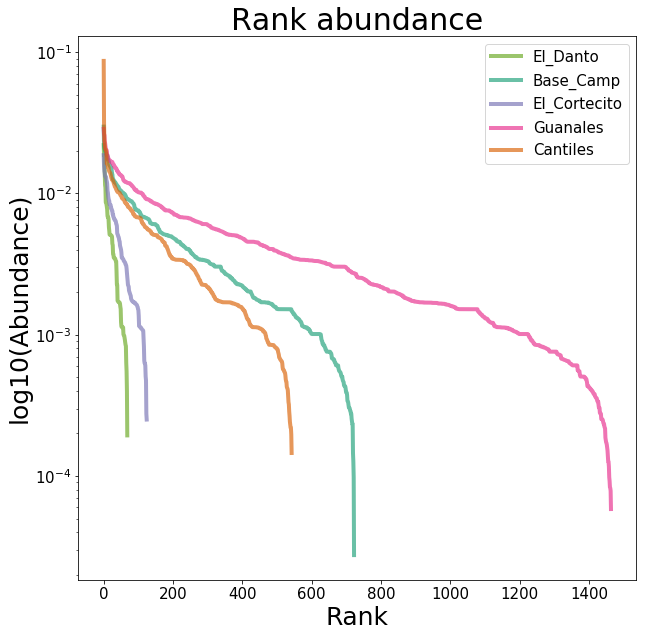

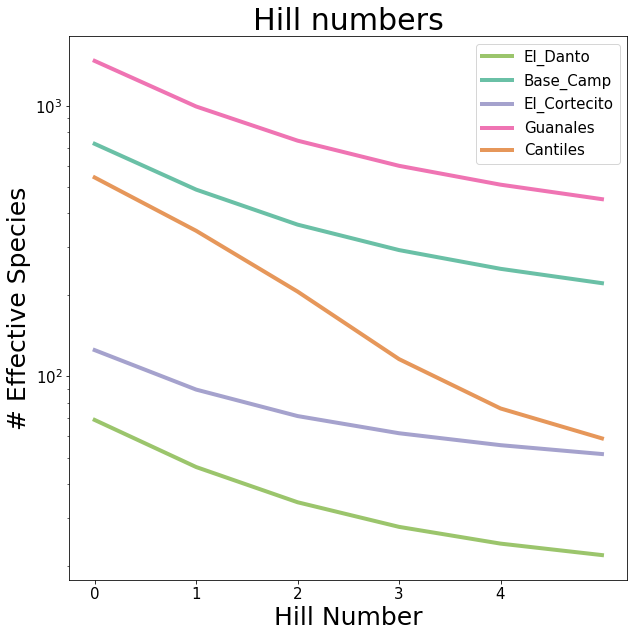

In [85]:
cmap = {'Base_Camp':"#1b9e77",
        'Cantiles':"#d95f02",
        'El_Cortecito':"#7570b3",
        'Guanales':"#e7298a",
        'El_Danto':"#66a61e"}
fig, ax = plt.subplots(figsize=(10,10))
for site, df in dfs.items():
    easyCGD.plot_RACs(df, ax=ax, color=cmap[site])
fig, ax = plt.subplots(figsize=(10,10))
for site, df in dfs.items():
    easyCGD.plot_hill_numbers(df, ax=ax, color=cmap[site])

In [191]:
for site in sites:
    n = easyCGD.hill_numbers(dfs[site].values, 5)
    print(site, len(dfs[site]), n[0], n/n[0])

El_Danto 349 69 [1.0 array([0.66995014]) 0.49644977450808325 0.40266084894606646
 0.3492045029775329 0.3167077097320382]
Base_Camp 2499 723 [1.0 array([0.67739109]) 0.5028342076495905 0.4049629871839393
 0.34527181584603556 0.30559102779907676]
El_Cortecito 703 125 [1.0 array([0.71476951]) 0.5705902091792975 0.4930176142471571
 0.44544763133978654 0.4130368351170106]
Guanales 4966 1464 [1.0 array([0.67853149]) 0.5073675655469706 0.40959988140625586
 0.348906303217354 0.3084088661167199]
Cantiles 1713 543 [1.0 array([0.63540249]) 0.3788067622221348 0.21322369533076022
 0.14014544661822398 0.10863019045696616]


## Plot dissimilarity between sites


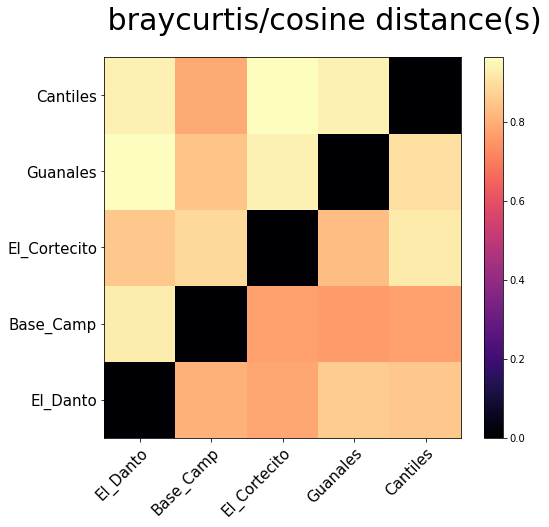

In [95]:
df = pd.concat(dfs.values(), ignore_index=False, axis=1, sort=True)
dat = df.fillna(value=0)
mx = easyCGD.plot_distances(dat, labels=df.columns, metric=["braycurtis", "cosine"])

# Parse out samples per site per year
The metadata are somewhat confused with respect to how sampling dates are recorded. Only 2014 has data for all sites, so lets pull out just that data, unfortunately it's the messiest year:
* 2012 & 2013 are labeled in "notes"
* 2014 is in "collection_note" I assume as BC/GU and the other 3 are labeled usefully
* 2015 is in "collection_note"

Here we get a mask for for each year, then apply it to the metadata table.

In [198]:
print(meta.columns)
#meta = meta.fill_na(value=0)
mask_2012 = np.core.defchararray.find(list(map(str, meta["notes"].values)), "2012")!=-1
mask_2013 = np.core.defchararray.find(list(map(str, meta["notes"].values)), "2013")!=-1
mask_2015 = np.core.defchararray.find(list(map(str, meta["collection_note"].values)), "2015")!=-1
mask_0 = meta["collection_note"] == 0
mask = mask_2015 | mask_0
meta_2014 = meta[~mask]
set(meta_2014["collection_note"])

Index(['sampleid', 'recordID', 'catalognum', 'fieldnum', 'institution_storing', 'collection_code', 'bin_uri', 'phylum_taxID', 'phylum_name', 'class_taxID', 'class_name', 'order_taxID', 'order_name', 'family_taxID', 'family_name', 'subfamily_taxID', 'subfamily_name', 'genus_taxID', 'genus_name', 'species_taxID', 'species_name', 'subspecies_taxID', 'subspecies_name', 'identification_provided_by', 'identification_method', 'identification_reference', 'tax_note', 'voucher_status', 'tissue_type', 'collection_event_id', 'collectors', 'collectiondate_start', 'collectiondate_end', 'collectiontime', 'collection_note', 'site_code', 'sampling_protocol', 'lifestage', 'sex', 'reproduction', 'habitat', 'associated_specimens', 'associated_taxa', 'extrainfo', 'notes', 'lat', 'lon', 'coord_source', 'coord_accuracy', 'elev', 'depth', 'elev_accuracy', 'depth_accuracy', 'country', 'province_state', 'region', 'sector', 'exactsite', 'image_ids', 'image_urls', 'media_descriptors', 'captions',
       'copyrigh

{'BC01',
 'BC02',
 'BC03',
 'BC04',
 'BC05',
 'BC06',
 'BC07',
 'BC08',
 'BC09',
 'BC10',
 'BC11',
 'BC12',
 'BC13',
 'BC14',
 'BC15',
 'BC16',
 'BC17',
 'BC18',
 'BC19',
 'BC20',
 'BC21',
 'BC22',
 'BC23',
 'BC24',
 'BC25',
 'BC26',
 'BC27',
 'BC28',
 'BC29',
 'BC30',
 'GU01',
 'GU02',
 'GU03',
 'GU04',
 'GU05',
 'GU06',
 'GU07',
 'GU08',
 'GU09',
 'GU10',
 'GU11',
 'GU12',
 'GU13',
 'GU14',
 'GU15',
 'GU16',
 'GU17',
 'GU18',
 'GU19',
 'GU20',
 'GU21',
 'GU22',
 'GU23',
 'GU24',
 'GU25',
 'GU26',
 'GU27',
 'GU28',
 'GU29',
 'Honduras 2014 Cantiles Trap 1',
 'Honduras 2014 Cantiles Trap 2',
 'Honduras 2014 Cantiles Trap 3',
 'Honduras 2014 Cantiles Trap 4',
 'Honduras 2014 Cantiles Trap 5',
 'Honduras 2014 Cantiles Trap 6',
 'Honduras 2014 Cantiles Trap 7',
 'Honduras 2014 Cantiles Trap 8',
 'Honduras 2014 El Cortecito Trap 1',
 'Honduras 2014 El Cortecito Trap 2',
 'Honduras 2014 El Cortecito Trap 3',
 'Honduras 2014 El Cortecito Trap 4',
 'Honduras 2014 El Cortecito xtra',
 'Hondura

In [251]:
sites_2012 = set(meta[mask_2012]["notes"])
sites_2013 = set(meta[mask_2013]["notes"])
sites_2014 = set(meta_2014["collection_note"])
sites_2015 = set(meta[mask_2015]["collection_note"])
yr_dict = {"2012":sites_2012,
           "2013":sites_2013,
           "2014":sites_2014,
           "2015":sites_2015,
          }

## A function to return the correct year for a sample
## given information from both notes/collection_note columns
def get_year(yr_dict, yr_string1, yr_string2):
    ret = ""
    for yr, sites in yr_dict.items():
        if yr_string1 in sites:
            with open("yrlog.txt", 'a+') as outfile:
                outfile.write("{} {} {}\n".format(yr, yr_string1, yr_string2))
            return yr
        elif yr_string2 in sites:
            with open("yrlog.txt", 'a+') as outfile:
                outfile.write("{} {} {}\n".format(yr, yr_string1, yr_string2))
            return yr
    return ret
get_year(yr_dict, 'Collected from August 1-3 2012', "wat")

'2012'

A modified version of the parsing function that will actually deal out the fasta files into a directory structure like this:
 
* 2012  
 * Base_Camp  
 * Guanales  
* 2013
 * Base_Camp  
 * Guanales  
* 2014
 * Base_Camp
 * Cantiles
 * El_Cortecito
 * El_Danto
 * Guanales
* 2015
 * Base_Camp
 * Cantiles
 * Guanales

In [252]:

def parse_fasta_by_year(fasta_file, output_path="fastas", quiet=True):

    ## Just automaticallyl clean up any fastadir that already exists and recreate the directory structure
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    for yr in yr_dict.keys():
        try:
            os.mkdir(output_path + "/{}".format(yr))
            for site in sites:
                outdir = output_path + "/{}/{}".format(yr, site)
                os.mkdir(outdir)
        except Exception as inst:
            print("Can't make outdir - {} - {}".format(outdir, inst))
    ## Parse the fasta file into a dictionary of sample IDs and sequences
    miss_dict = {}
    with open(fasta_file, 'r') as fasta:
        for line1,line2 in itertools.zip_longest(*[fasta]*2):
            key = line1.strip().strip(">").split("|")[0]
            seq = line2.strip()

            try:
                otu = str(meta.loc[key]["bin_uri"])
                if otu == "nan":
                    raise Exception("Sample w/o bin_uri")
                site = meta.loc[key]["exactsite"]
                yr = get_year(yr_dict, meta.loc[key]["collection_note"],meta.loc[key]["notes"])
                if not yr:
                    raise Exception("no year for {}".format(key))
                with open("{}/{}/{}/{}.fasta".format(output_path, yr, site, otu), 'a+') as outfile:
                    outfile.write("{}\n{}\n".format(">"+key, seq))
                with open("logfile.txt", 'a+') as log:
                    log.write("{}/{}/{}/{}.fasta\n".format(output_path, yr, site, otu))

            except Exception as inst:
                miss_dict[key] = seq
                if not quiet:
                    print("{} failed - {}".format(key, inst))
                pass
    return miss_dict
missed = parse_fasta_by_year("fasta.fas", "fastas", quiet=True)

In [254]:
print(len(missed.keys()), "samples with no BIN")


1715 samples with no BIN


## Fastas are unaligned, so you have to do an alignment per species, per site, per time
Takes a while.

In [ ]:
for yr in yr_dict.keys():
    for site in sites:
        print(yr, site)
        fdir = fastadir + "/{}/{}".format(yr, site)
        try:
            os.rmdir(fdir)
        except:
            pass
        for f in glob.glob(fdir + "/*"):
            #print(f)
            align(f)

## Now calculate pi per species and make the pi distribution file per site, per time

In [258]:
split_dfs = {}
for yr in yr_dict.keys():
    split_dfs[yr] = {}
    for site in sites:
        try:
            fdir = fastadir + "/{}/{}".format(yr, site)
            print(fdir)
            split_dfs[yr][site] = easyCGD.get_pis_from_fastas(fasta_dir=fdir,
                                                    outfile=os.path.join(fastadir+"/{}/".format(yr), "{}.pis".format(site)),
                                                    colname=site)
        except Exception as inst:
            print("Failed {}/{}".format(yr, site))

/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas//2012/El_Danto
Error in getting pis No fasta files in this directory: []
Failed 2012/El_Danto
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas//2012/Base_Camp
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas//2012/El_Cortecito
Error in getting pis No fasta files in this directory: []
Failed 2012/El_Cortecito
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas//2012/Guanales
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas//2012/Cantiles
Error in getting pis No fasta files in this directory: []
Failed 2012/Cantiles
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas//2013/El_Danto
Error in getting pis No fasta files in this directory: []
Failed 2013/El_Danto
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas//2013/Base_Camp
/home/isaac/SGD_empirical/empirical_cusuco_arthropods/fastas//2013/El_Cortecito
Error in getting pis No fasta files in this directory: []
Fail

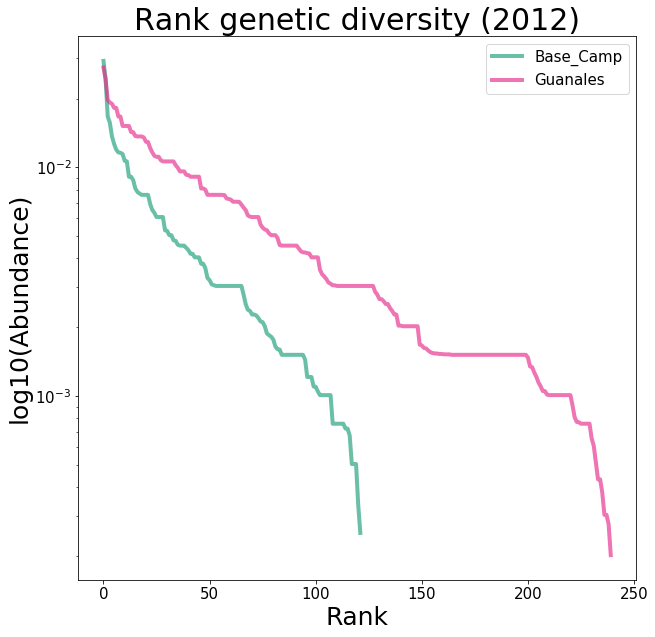

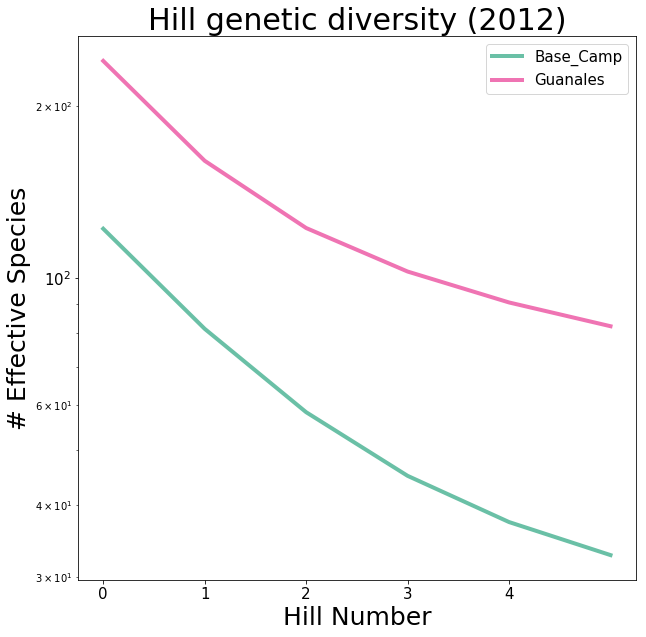

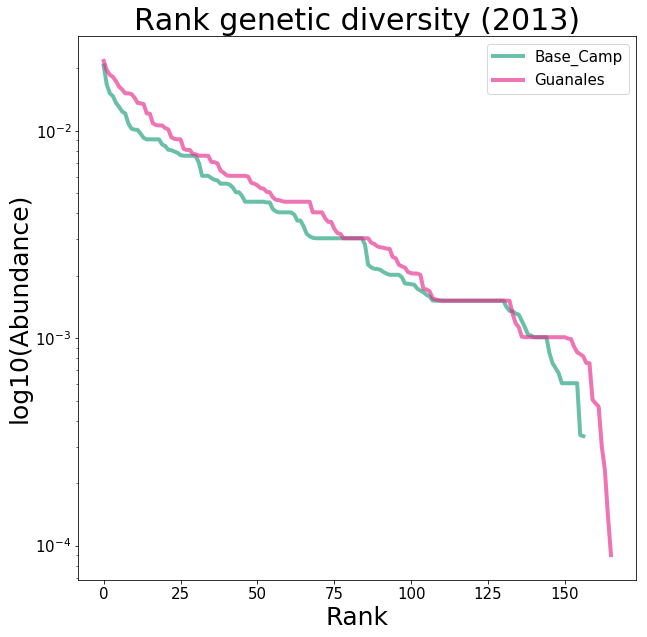

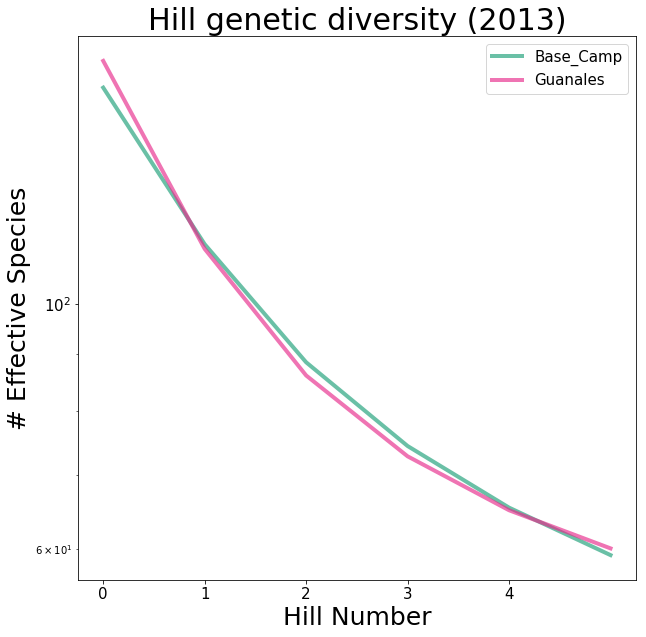

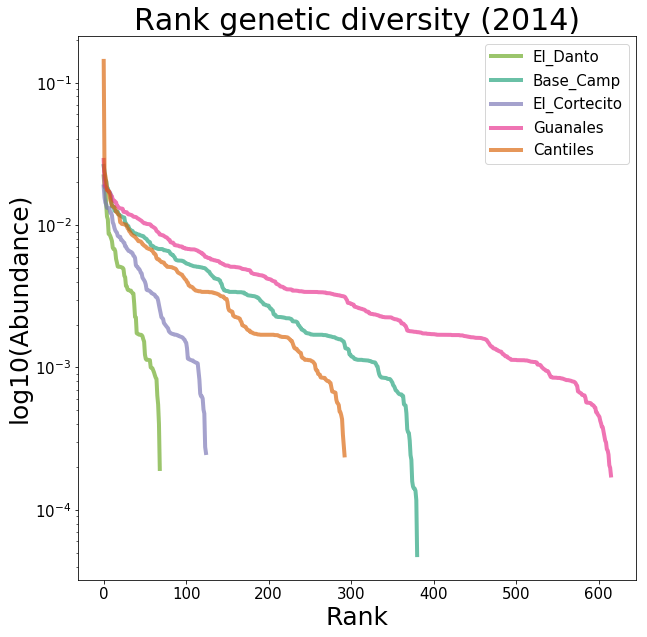

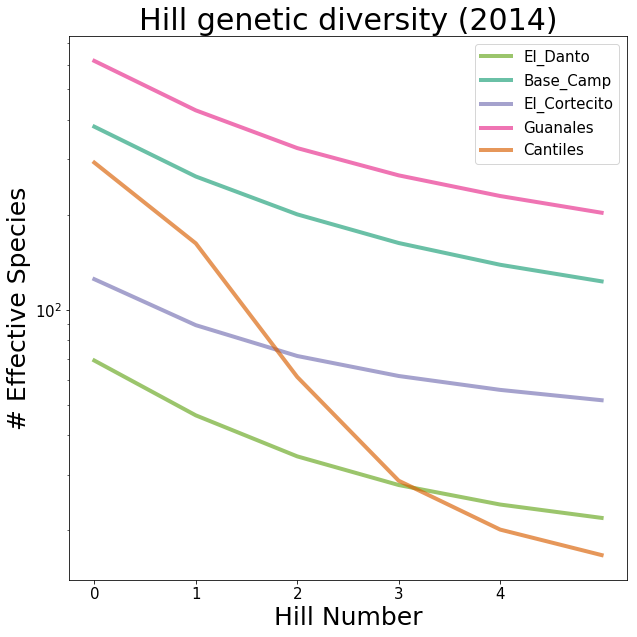

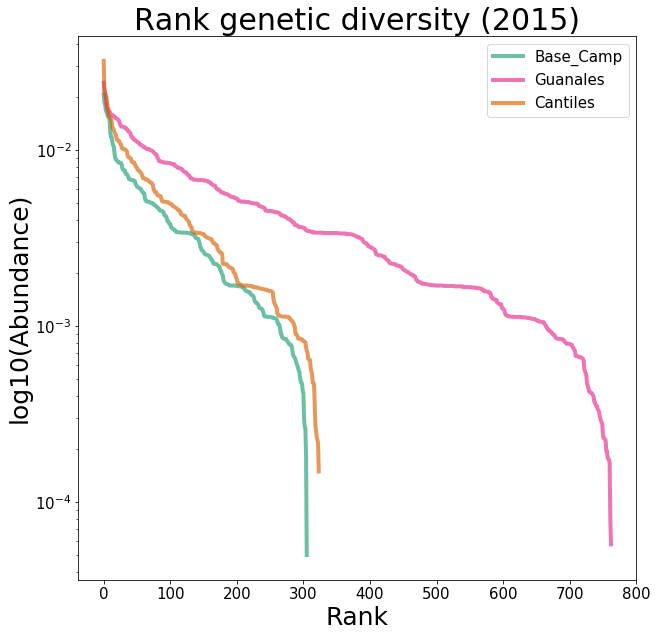

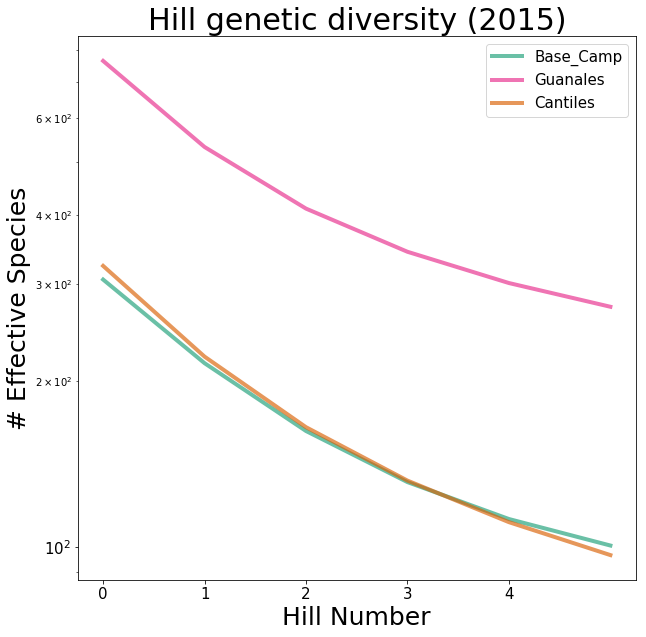

In [259]:
cmap = {'Base_Camp':"#1b9e77",
        'Cantiles':"#d95f02",
        'El_Cortecito':"#7570b3",
        'Guanales':"#e7298a",
        'El_Danto':"#66a61e"}

for yr in yr_dict.keys():
    fig, ax = plt.subplots(figsize=(10,10))
    for site, df in split_dfs[yr].items():
        easyCGD.plot_RACs(df, title="Rank genetic diversity ({})".format(yr), ax=ax, color=cmap[site])
    fig, ax = plt.subplots(figsize=(10,10))
    for site, df in split_dfs[yr].items():
        easyCGD.plot_hill_numbers(df, title="Hill genetic diversity ({})".format(yr), ax=ax, color=cmap[site])


In [272]:
hill_dict = pd.DataFrame([], columns = ["yr", "site", "nsamps", "R", "H1", "H2", "H3", "H4", "H5"])
for yr in yr_dict.keys():
    for site in sites:
        try:
            n = easyCGD.hill_numbers(split_dfs[yr][site].values, 5)
            normed = n/n[0]
            hill_dict = hill_dict.append({"yr":yr, "site":site,\
                                          "nsamps":len(split_dfs[yr][site]),
                                          "R":n[0], "H1":normed[1][0], "H2":normed[2],
                                          "H3":normed[3], "H4":normed[4], "H5":normed[5]}, ignore_index=True)
        except:
            pass
hill_dict

,yr,site,nsamps,R,H1,H2,H3,H4,H5
0,2012,Base_Camp,570,122,0.667950,0.477249,0.369236,0.306452,0.268240
1,2012,Guanales,1277,240,0.668552,0.509804,0.427749,0.377599,0.343112
2,2013,Base_Camp,787,157,0.721465,0.564017,0.473662,0.416555,0.377305
3,2013,Guanales,879,166,0.675734,0.518976,0.438466,0.391837,0.361882
4,2014,El_Danto,349,69,0.669950,0.496450,0.402661,0.349205,0.316708
5,2014,Base_Camp,1460,381,0.694822,0.526852,0.427384,0.364576,0.322972
6,2014,El_Cortecito,703,125,0.714770,0.570590,0.493018,0.445448,0.413037
7,2014,Guanales,2575,616,0.696800,0.528881,0.433328,0.372648,0.329782
8,2014,Cantiles,1100,293,0.554324,0.208879,0.097863,0.068472,0.056836
9,2015,Base_Camp,1192,306,0.705082,0.531060,0.428969,0.367652,0.329103


In [264]:
hill_dict = pd.DataFrame(columns=["name", "wat"])
hill_dict

,name,wat
